<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; ESO Science Archive Programmatic: HOWTOs

## HOW TO Query, Filter, Pre-process and Visualize Spectroscopic Data

This notebook guides users on how to query science-ready spectral databases from ESO, filter the desired observations, and perform cutouts of specific spectral regions before downloading the data. It provides an example science case focusing on creating a spectral sequence for the well-known Beta Pictoris system. The presence of exo-comets is inferred from the stochastic appearances and disappearances of narrow absorption components in gas tracers such as Calcium, caused by the sublimated gas tails of the comets eclipsing our line of sight towards the star.

In addition to querying and downloading data, this notebook also demonstrates how to visualize the spectra and create animated GIFs to illustrate spectral changes over time. The GIFs provide dynamic views of the spectral data, including both cumulative and non-cumulative perspectives, enhancing the analysis of temporal variations.

**Usage**: You can access this file as an interactive jupyter notebook, which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will.

**Version**: Please note that this notebook uses Python version 3.10.15 and Jupyter Notebook version 6.4.10. Compatibility with other versions cannot be guaranteed.

**Authors**: Catalina Sáez Carvajal & Ashley Thomas Barnes

**Table of Content**

0. [**Imports - inc. ESOAsg package**](#imports)
1. [**Query by Coordinates: Cone search**](#query_by_coordinate) 
2. [**Downloading the Data**](#download)
3. [**Explore data**](#explore_data)
    1. [**Retrieving and Visualizing Spectral Data**](#obtaining_spectra)
    3. [**Visualizing Spectra with a Static Plot**](#static_plot) 
    4. [**Animation of Cumulative Spectral Data**](#gif_cum) 
    5. [**Animation of Non-Cumulative Spectral Data**](#gif_noncum)


---
## <a id='imports'>0. Imports - inc. ESOAsg package</a>

In [45]:
from ESOAsg import archive_observations # ESO Archive Observations

from astropy.coordinates import SkyCoord # Astropy coordinates
from astropy.io import fits # Astropy FITS files
import astropy.constants as const # Astropy constants
import astropy.units as u # Astropy units
import matplotlib.pyplot as plt # Matplotlib
import numpy as np # Numpy
from matplotlib.animation import FuncAnimation, PillowWriter  # Libraries for creating animations

# Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.dpi'] = 200

---
## <a id='query_by_coordinate'>1. Query by Coordinates: Cone search </a>

There are several ways to pose a query by coordinates, depending on the specific use case and the type of data you are seeking. For more details, please refer to the [How to Query for Reduced Data Notebook](https://archive.eso.org/programmatic/HOWTO/jupyter/how_to_query_for_reduced_data/ESO_How_to_query_for_reduced_data.html).

In this example, we are interested in finding datasets within 5 arcseconds of _Beta Pictoris_, making a cone search particularly useful. You can either use the object's equatorial coordinates directly or employ a name resolver like SESAME (from CDS) to retrieve them. This defines a circular search region characterized by three parameters: right ascension (RA), declination (Dec), and radius, all expressed in degrees.


In [2]:
# Defining the position via SESAME name resolver, and the search radius

star_name = 'Beta Pictoris'
star_position = []
star_position = SkyCoord.from_name(star_name)
print('{}: {}'.format(star_name, SkyCoord.from_name(star_name).to_string('hmsdms')))

Beta Pictoris: 05h47m17.0876901s -51d03m59.441135s


Now, to look for a given reduced dataset, we perform the cone search intersecting a circle of 5 arcseconds around our target. The query is written in ADQL (Astronomical Data Query Language).

In this [TAP query](https://archive.eso.org/tap_obs/sync?REQUEST=doQuery&LANG=ADQL&MAXREC=200&FORMAT=txt&QUERY=SELECT%20TOP%2010%0atarget_name,%20dp_id,%20s_ra,%20s_dec,%20t_exptime,%20em_min,%20em_max,%20dataproduct_type,%20instrument_name,%20obstech,%20abmaglim,%20proposal_id,%20obs_collection%0aFROM%0aivoa.ObsCore%0aWHERE%0aINTERSECTS(s_region,CIRCLE(%27ICRS%27,86.82119870875,-51.06651142639,5.0%2f3600.))%20=%201%0aAND%0a(%0ainstrument_name%20LIKE%20%27HARPS%27%0a)%0aAND%0a(%0adataproduct_type%20LIKE%20%27spectrum%27%0a)%0aAND%0aem_min%3c3.933643e-07%0aAND%0aem_max%3e3.933683e-07%0aAND%0asnr%3e300%0aAND%0aem_res_power%3e40000) query, we specify:
- **Radius (``radius``)**: Filtering of 5 arcsec around position 
- **Spectral Resolving Power (`em_res_power`)**: Filtering datasets with a resolving power greater than 40000.
- **Data Product Type (`data_types`)**: Filtering for spectral data.
- **Spectral Bounds (`em_min` and `em_max`)**: Selecting spectra that cover the vacuum wavelength range expressed in meters. Note that here we include the `enclosed=False`, which states the condition will be `em_min < em_min` and `em_max > em_max`.
- **Signal to Noise Ratio (`snr`)**: Selecting datasets with SNR greater than 300.
- **Instrument Name (`instrument_name`)**: Restricting the search to objects observed by HARPS.
- **Top 10 Objects**: Selecting the top 10 objects with the highest SNR.

Or 

```SQL
SELECT TOP 10
    target_name, dp_id, s_ra, s_dec, t_exptime, em_min, em_max, dataproduct_type, instrument_name, obstech, abmaglim, proposal_id, obs_collection
FROM
    ivoa.ObsCore
WHERE
    INTERSECTS(s_region,CIRCLE('ICRS',86.82119870875,-51.06651142639,5.0/3600.)) = 1
AND
    (
    instrument_name LIKE 'HARPS'
    )
AND
    (
    dataproduct_type LIKE 'spectrum'
    )
AND 
    em_min<3.933643e-07
AND 
    em_max>3.933683e-07
AND 
    snr>300
AND 
    em_res_power>40000
```

For more information on the ADQL query language, refer to the [IVOA documentation](https://www.ivoa.net/documents/ObsCore/20170509/REC-ObsCore-v1.1-20170509.pdf).


In [44]:
result_from_queries = archive_observations.query_from_radec(star_position, radius=5, data_types='spectrum', top=10, 
                                                            em_min=3933.643e-10, em_max=3933.683e-10, enclosed=False,
                                                            snr=300, em_res_power=40000, instruments='HARPS')

[WORKING] :: Running query 1 to the ESO archive (out of 1 total)
[INFO]    :: A total of 10 entries has been retrieved


In [4]:
result_from_queries.sort(['instrument_name', 'dp_id'])
result_from_queries.show_in_notebook(show_row_index=False)

target_name,dp_id,s_ra,s_dec,t_exptime,em_min,em_max,dataproduct_type,instrument_name,obstech,abmaglim,proposal_id,obs_collection
,,deg,deg,s,m,m,,,,mag,,
HD039060,ADP.2017-01-16T01:15:41.423,86.82165,-51.0676,39.998,3.78179e-07,6.91272e-07,spectrum,HARPS,ECHELLE,--,098.C-0739(A),HARPS
HD039060,ADP.2018-03-30T01:06:45.304,86.819671,-51.06609,71.048,3.7817399999999996e-07,6.91263e-07,spectrum,HARPS,ECHELLE,--,098.C-0739(A),HARPS
HD039060,ADP.2018-03-31T01:10:10.165,86.819964,-51.06607,46.328,3.78172e-07,6.91263e-07,spectrum,HARPS,ECHELLE,--,098.C-0739(A),HARPS
HD039060,ADP.2018-03-31T01:10:10.251,86.819488,-51.0658,46.328,3.78172e-07,6.91263e-07,spectrum,HARPS,ECHELLE,--,098.C-0739(A),HARPS
HD039060,ADP.2018-03-31T01:10:10.261,86.819502,-51.0658,46.328,3.78172e-07,6.91263e-07,spectrum,HARPS,ECHELLE,--,098.C-0739(A),HARPS
HD039060,ADP.2018-03-31T01:10:10.345,86.819514,-51.0657,46.328,3.78172e-07,6.91263e-07,spectrum,HARPS,ECHELLE,--,098.C-0739(A),HARPS
HD039060,ADP.2018-03-31T01:10:10.349,86.819674,-51.06572,46.328,3.78172e-07,6.91263e-07,spectrum,HARPS,ECHELLE,--,098.C-0739(A),HARPS
HD039060,ADP.2018-05-05T01:06:09.227,86.820881,-51.06751,55.268,3.7817500000000004e-07,6.91269e-07,spectrum,HARPS,ECHELLE,--,098.C-0739(A),HARPS
HD039060,ADP.2018-05-05T01:06:09.303,86.820797,-51.06769,57.618,3.7817500000000004e-07,6.91269e-07,spectrum,HARPS,ECHELLE,--,098.C-0739(A),HARPS


---
## <a id='download'>2. Download the cutout Archive Data Products </a>

In this section, we first create cutouts of specific spectral regions before downloading the data. 

For this analysis, we focus on selecting files that fall within a defined wavelength range to examine a region of interest, specifically around the CaII K line.

This is done by passing the `dp_id` column and our `em_min_cut` and `em_max_cut` to `archive_observations.download_cutout` (note: not `archive_observations.download`, which would return the full spectrum).

In [ ]:
# Specify the parent directory; update this to match your own directory structure
output_dir = './data/' 

em_min_cut = 350e-9 # 540 nm - minimum wavelength
em_max_cut = 450e-9 # 570 nm - maximum wavelength

for result_table in result_from_queries:
    archive_observations.download_cutout([result_table['dp_id']], output_dir=output_dir, em_min_cut=em_min_cut, em_max_cut=em_max_cut)

---
## <a id='explore_data'>3. Explore the data... </a>

### <a id='obtaining_spectra'>3.1 Retrieving and Visualizing Spectral Data</a>

**Function: Spectra_parameters**

First, we define the function `Spectra_parameters`, which calculates spectral parameters using a reference wavelength (`ref`), a resolution (`R`), and a variable range (`var`). This function constructs the wavelength array, computes the corresponding velocities, and then saves the velocity data to a CSV file.


In [6]:
import coronagraph as cg  # Module for simulating the performance of coronagraphs
import pandas as pd  # Library for data manipulation and analysis

In [35]:
def Spectra_parameters(ref=3933.7, R=115000, var=20):
    """Calculate spectral parameters based on reference wavelength, resolution, and variable range
    
    Parameters:
    ref (int): Reference wavelength in nm (CaII K in the air expressed in Angstrom)
    R (int): Spectral resolution
    var (int): Variable range in nm

    Returns:
    wl (array): Wavelength array
    dwl (array): Wavelength step size
    velocity (array): Velocity array
    vel (DataFrame): DataFrame with velocities
    lammin (int): Minimum wavelength
    lammax (int): Maximum wavelength
    """

    # Define the wavelength range around the reference
    lammin = ref-var
    lammax = ref+var
    
    # Construct the wavelength array and wavelength step size using the coronagraph module
    c = const.c.to('km/s').value # Speed of light in km/s
    wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, R)
    velocity = c*((wl-ref)/wl) # Calculate the velocity for each wavelength
    vel = pd.DataFrame(data=velocity,columns=['Velocity']) # Create a DataFrame with the velocities
    vel.to_csv('./data/velocity.csv') #Save the velocity data to a CSV file
    
    return wl, dwl, velocity, vel, lammin, lammax

#Calculate spectral parameters
wl, dwl, velocity, vel, lammin, lammax = Spectra_parameters()

**Processing FITS Files and Plotting Spectra**

In this section, we process the FITS files that were previously downloaded. For each file, we open it, extract the spectral data from extension 1, normalize the flux, calculate the velocity, and generate a plot of the spectral data.

 The processed data is stored in a DataFrame for further analysis, while observation dates are recorded in a separate DataFrame.

In [ ]:
for i in range(len(result_from_queries)):

    # Construct the full path to the FITS file
    file_name = f'{output_dir}/{result_from_queries[i]["dp_id"]}_TARGET_{int(em_min_cut*1e9)}-{int(em_max_cut*1e9)}.fits'

    hdulist = fits.open(file_name) # Open the FITS file
    scidata = hdulist[1].data # Bintable extension
    wave = scidata[0][0] # Wavelength data
    flux = scidata[0][1] # Flux data
    contf = flux[np.logical_and(wave > lammin, wave < lammax)] #Select fluxes within the wavelength range
    natwav = wave[np.logical_and(wave > lammin, wave < lammax)] # Select wavelengths within the range
    natf = contf/np.percentile(contf, 95) # Normalize the flux to the 95th percentile
    flr = cg.downbin_spec(natf, natwav, wl, dlam=dwl) # Downsample the spectrum 
    
    # For subsequent iterations (i > 0), add the new flux data to the existing DataFrame df.
    if i==0:
        # If this is the first iteration (i == 0), create a new DataFrame df to store the flux data.
        df = pd.DataFrame(data=flr, columns=[result_from_queries[i]['dp_id']])
        # Create another DataFrame df2 to store the observation date (MJD) of the file.
        df2 = pd.DataFrame(data=[[result_from_queries[i]['dp_id'],hdulist[0].header['MJD-OBS']]],columns=['dp_id', 'MJD'])
    
    else:
        # For subsequent iterations (i > 0), add the new flux data to the existing DataFrame df.
        df[result_from_queries[i]['dp_id']] = flr
        
        # Add the new observation date to the existing DataFrame df2.
        df2.loc[i] = [result_from_queries[i]['dp_id'], hdulist[0].header['MJD-OBS']]

### <a id='static_plot'>3.2 Visualizing Spectra with a Static Plot</a>

To begin, we generate a static plot that displays the normalized flux as a function of velocity for all spectra in our dataset. For clarity, individual spectra are shown in grey, while the mean spectrum is highlighted in red to improve visualization and facilitate comparison.


First, we create a static plot showing the normalized flux versus velocity for all the spectra in our dataset. For clarity, we overlay individual spectra in grey and plot the mean spectrum in red to enhance visualization.


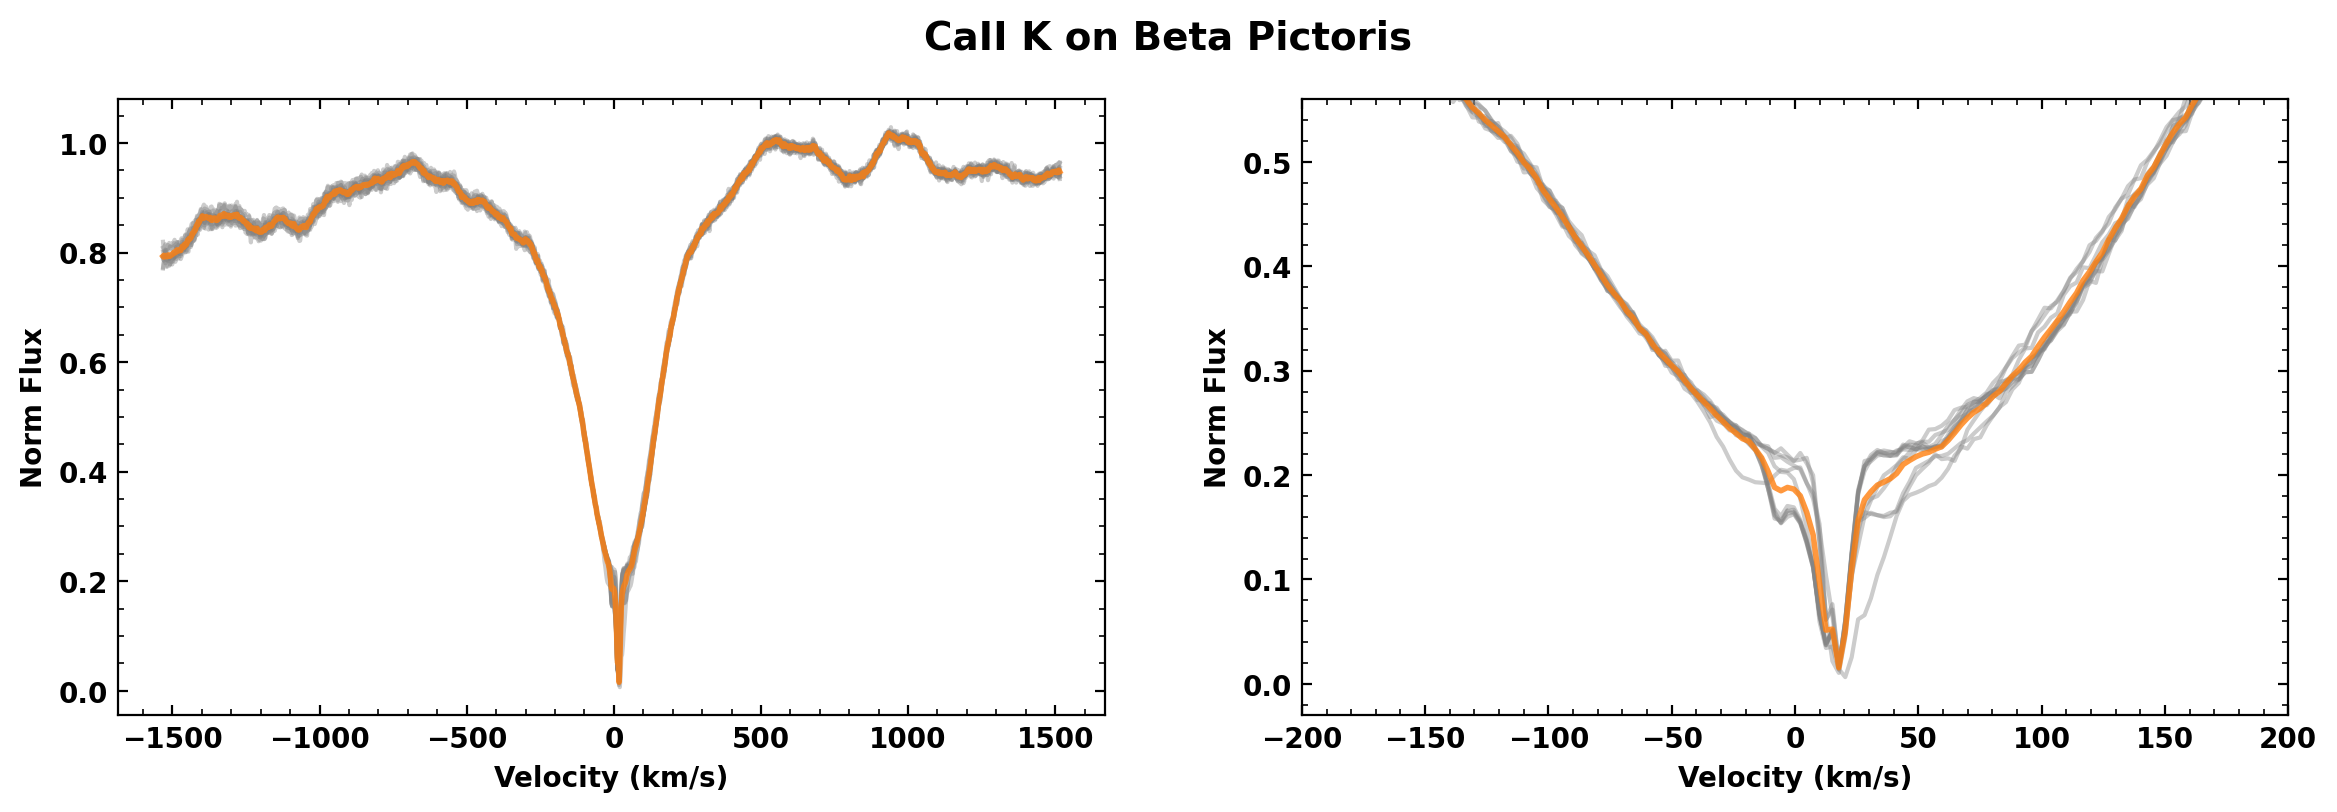

In [42]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

# Loop through each spectrum in the DataFrame df2
for i in range(df2.shape[0]):
    # Plot the normalized flux against velocity for each individual spectrum in grey with some transparency
    ax[0].plot(velocity,df[df2['dp_id'][i]].values, c='grey', alpha=0.4)
    ax[1].plot(velocity,df[df2['dp_id'][i]].values, c='grey', alpha=0.4)

# Plot the mean of all spectra in red with a slightly thicker line and reduced transparency to highlight it

ax[0].plot(velocity,df.mean(axis=1).values, color='C1', lw=2, alpha=0.8)
ax[0].set_xlabel('Velocity (km/s)')
ax[0].set_ylabel('Norm Flux')

ax[1].plot(velocity,df.mean(axis=1).values, color='C1', lw=2, alpha=0.8)
ax[1].set_xlabel('Velocity (km/s)')
ax[1].set_ylabel('Norm Flux')
ax[1].set_xlim(-200,200)
ax[1].set_ylim(-0.03,0.56)

plt.suptitle('CaII K on Beta Pictoris', fontsize=14, fontweight='bold')
plt.savefig('./figures/BetaPictoris_static.png', transparent=True)

### <a id='gif_cum'>3.3 Animation of Cumulative Spectral Data</a>

We create an animated GIF that visualizes cumulative spectral data over time. This animation allows us to observe how the spectral features evolve as new data is accumulated.


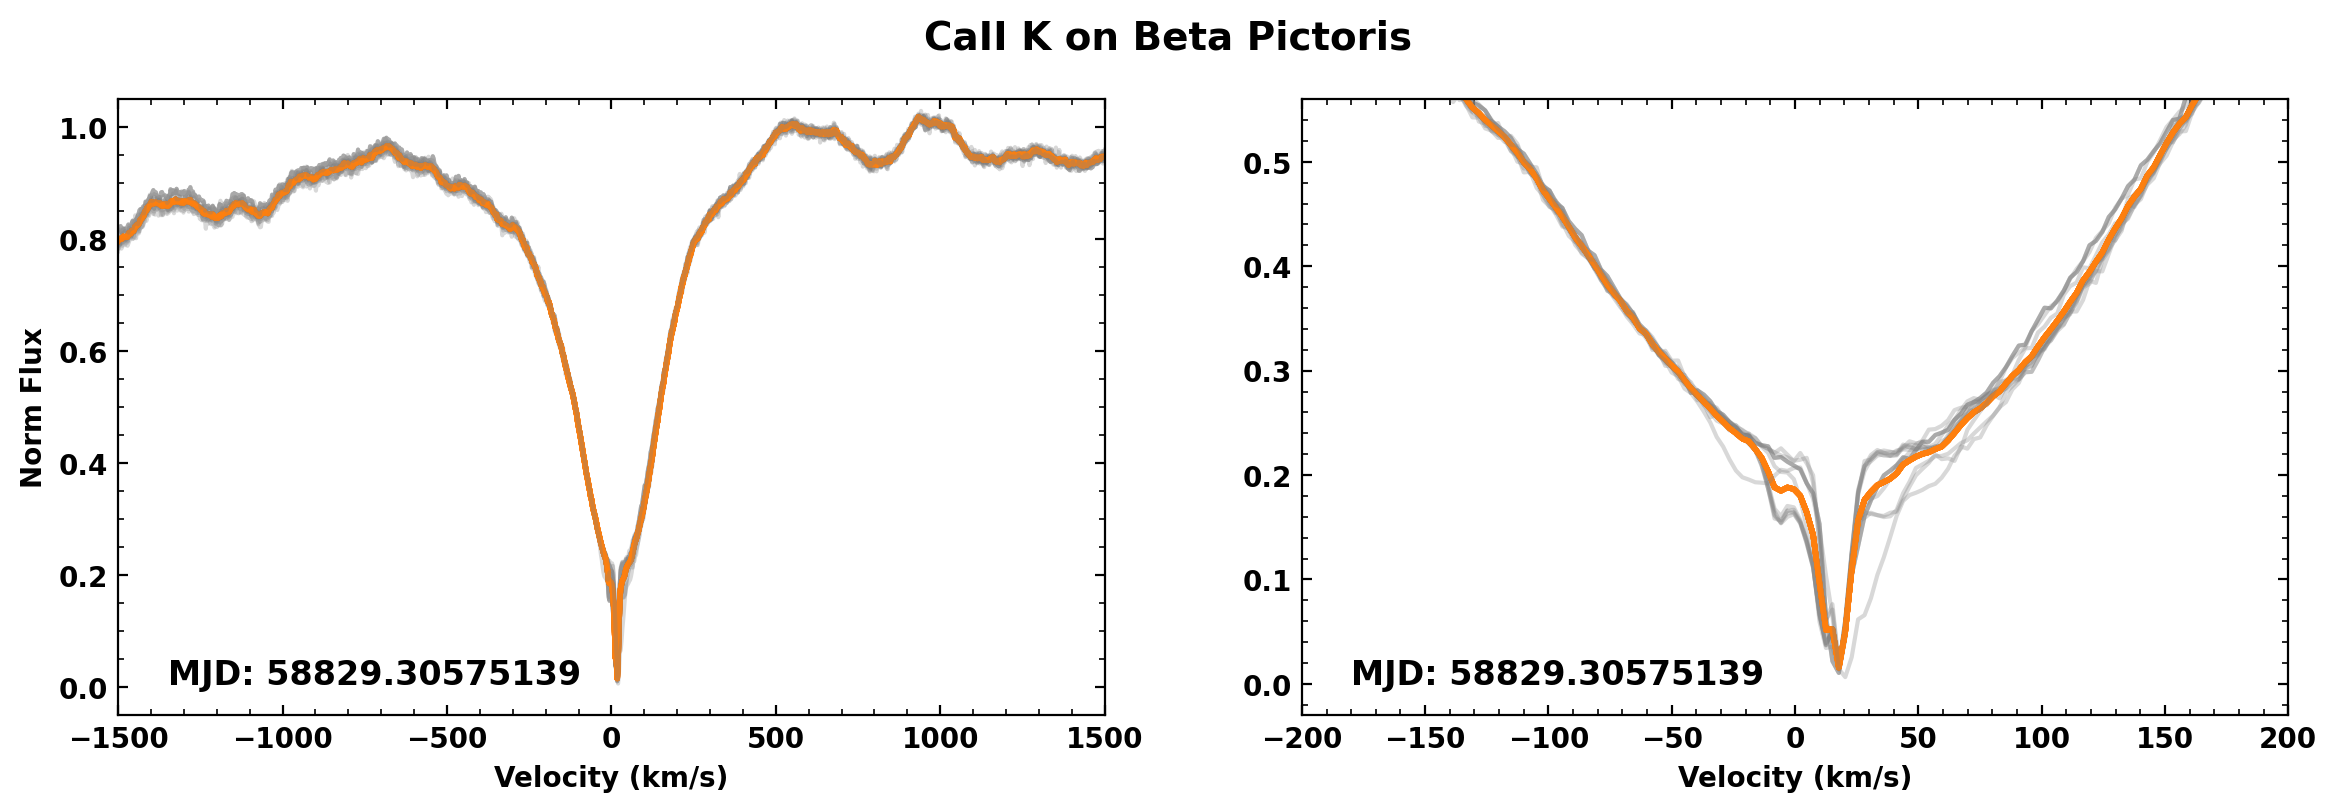

In [33]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(1,2,figsize=(14,4))
plt.suptitle('CaII K on Beta Pictoris', fontsize=14, fontweight='bold')

nframes = df.shape[1] # Determine the number of frames based on the number of columns in the DataFrame

'Cumulative Plot'

# Function to animate each frame
def animate(i):

    # Plot the mean values of the DataFrame as a red line
    line, = ax[0].plot(velocity, df.mean(axis=1).values, color='C1', lw=2, alpha=0.8)
    line1, = ax[1].plot(velocity, df.mean(axis=1).values, color='C1', lw=2, alpha=0.8)
    
    # Plot the values of the DataFrame for a specific dp_id as a grey line
    line2, = ax[0].plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=0.3)
    line3, = ax[1].plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=0.3)

    for txt in ax[0].texts:
        txt.set_visible(False) # Hide the previous text object
    for txt in ax[1].texts:
        txt.set_visible(False) # Hide the previous text object

    ax[0].text(0.05, 0.05, f'MJD: {df2["MJD"][i]}', transform=ax[0].transAxes, fontsize=12, fontweight='bold')
    ax[1].text(0.05, 0.05, f'MJD: {df2["MJD"][i]}', transform=ax[1].transAxes, fontsize=12, fontweight='bold')
    
    ax[0].set_xlabel('Velocity (km/s)')
    ax[0].set_ylabel('Norm Flux')
    ax[1].set_xlabel('Velocity (km/s)')

    ax[0].set_xlim(-1500,1500)
    ax[0].set_ylim(-0.05,1.05)

    ax[1].set_xlim(-200,200)
    ax[1].set_ylim(-0.03,0.56)
    
    return line, line1, line2, line3
        
# Create the animation object
ani = FuncAnimation(fig, # The figure to animate
                    animate, # The function to call for each frame
                    interval=4, # Delay between frames in milliseconds
                    blit=True,  # Optimize by only redrawing parts that have changed
                    repeat=True, # Repeat the animation indefinitely
                    frames=range(nframes), # Number of frames in the animation
                    cache_frame_data=False) 
   
ani.save('./figures/BetaPictoris_faster.gif', dpi=300, writer=PillowWriter(fps=10))

### <a id='gif_noncum'>3.4 Animation of Non-Cumulative Spectral Data</a>

We also create an animated GIF that displays spectral data over time without accumulating it. This animation provides a dynamic view of the individual spectra as they are plotted sequentially.


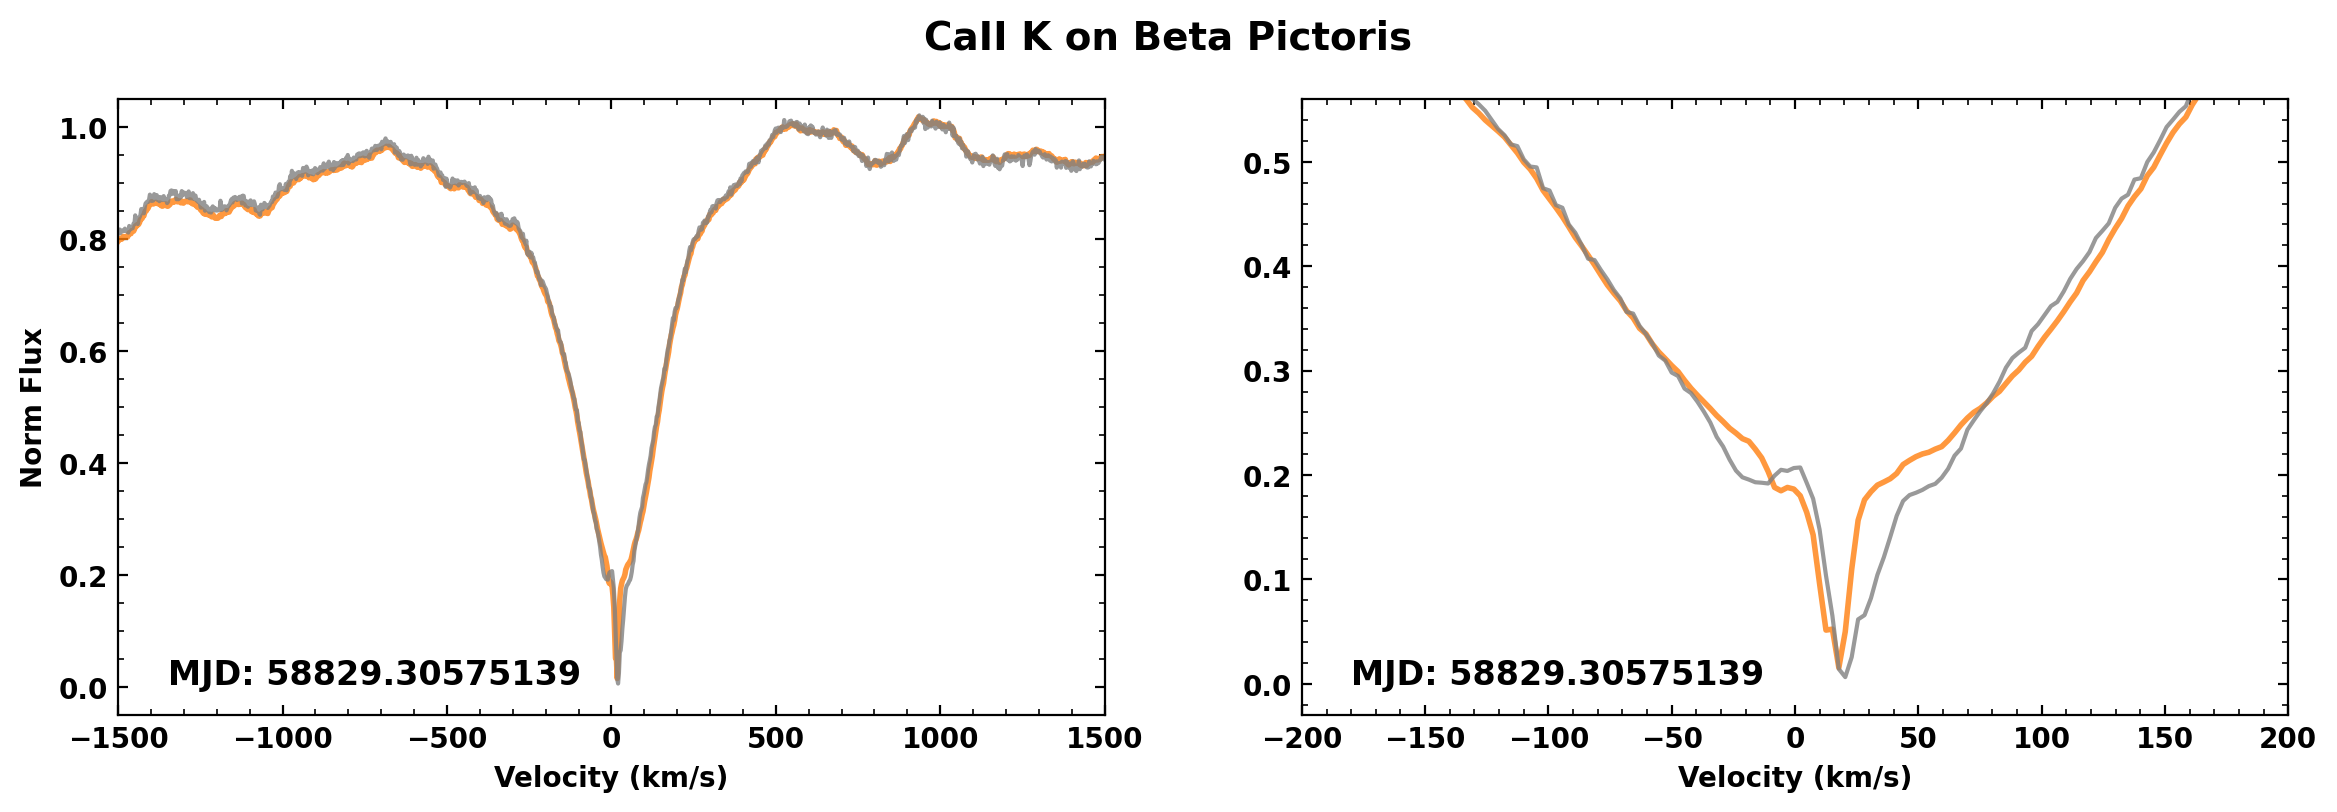

In [34]:
'Not Cumulative Plot'

fig, ax = plt.subplots(1,2,figsize=(14,4))
plt.suptitle('CaII K on Beta Pictoris', fontsize=14, weight='bold')

# Function to animate each frame
def animate(i):
    ax[0].clear() # Clear the previous plot to avoid overlap of lines
    ax[1].clear() # Clear the previous plot to avoid overlap of lines
    
    # Plot the mean values of the DataFrame as a red line
    line, = ax[0].plot(velocity, df.mean(axis=1).values, color='C1', lw=2, alpha=0.8)
    line1, = ax[1].plot(velocity, df.mean(axis=1).values, color='C1', lw=2, alpha=0.8)

    # Plot the values of the DataFrame for a specific dp_id as a grey line
    line2, = ax[0].plot(velocity, df[df2['dp_id'][i]].values, color='grey', alpha=0.8)
    line3, = ax[1].plot(velocity, df[df2['dp_id'][i]].values, color='grey', alpha=0.8)
    
    for txt in ax[0].texts:
        txt.set_visible(False) # Hide the previous text object
    for txt in ax[1].texts:
        txt.set_visible(False) # Hide the previous text object

    ax[0].text(0.05, 0.05, f'MJD: {df2["MJD"][i]}', transform=ax[0].transAxes, fontsize=12, fontweight='bold')
    ax[1].text(0.05, 0.05, f'MJD: {df2["MJD"][i]}', transform=ax[1].transAxes, fontsize=12, fontweight='bold')

    ax[0].set_xlabel('Velocity (km/s)')
    ax[0].set_ylabel('Norm Flux')
    ax[1].set_xlabel('Velocity (km/s)')

    ax[0].set_xlim(-1500,1500)
    ax[0].set_ylim(-0.05,1.05)

    ax[1].set_xlim(-200,200)
    ax[1].set_ylim(-0.03,0.56)

    return line, line2, line3, line1
        
ani = FuncAnimation(fig, animate, interval=4, blit=True, repeat=True, frames=range(nframes),cache_frame_data=False)    

ani.save('./figures/BetaPictoris_noncum.gif', dpi=300, writer=PillowWriter(fps=10))